# WGAN

## Import Necessary Packages

In [16]:
import numpy as np
from numpy.random import randn
from numpy.random import randint

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Reshape, Dropout, Input, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import mnist as mnist 
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend
from tensorflow.keras.constraints import Constraint

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## Data & Preprocessing

In [107]:
def Input_Data():
    
    (Xtrain,_) , (_,_) = mnist.load_data()

    #     Xtrain = (Xtrain.astype('float32')/127.50) - 1
#     Scaler = StandardScaler()

#     Xtrain_shape = Xtrain.shape

#     Xtrain = pd.DataFrame(Xtrain.reshape(Xtrain_shape[0],-1))
#     Xtrain = Scaler.fit_transform(Xtrain)
#     Xtrain = np.array(Xtrain)
#     Xtrain = np.reshape(Xtrain,[Xtrain_shape[0],Xtrain_shape[1],Xtrain_shape[2]])
    Xtrain = (Xtrain-127.5)/127.5
    Xtrain = Xtrain[...,np.newaxis]
    Xtrain = Xtrain.astype('float64')
    
    return Xtrain

## Define Model

### Generative Network - Discriminative Network - GAN

In [46]:
class Clip_limit(Constraint):

    def __init__(self, clip_value):
        self.clip_value = clip_value

    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
 

    def get_config(self):
        return {'clip_value': self.clip_value}
        
        
class GAN:   
    
    ### Generative Network
    def build_Gen(self,z_dim):
        
        init = tf.keras.initializers.RandomNormal(stddev=0.02)
        
        self.Gen = Sequential()
    
        self.Gen.add(Dense(128*7*7,input_dim=z_dim, kernel_initializer=init))
        self.Gen.add(LeakyReLU(0.2))
        self.Gen.add(Reshape((7,7,128)))
        
        self.Gen.add(Conv2DTranspose(128,kernel_size=4,strides=2, padding='same',kernel_initializer=init))
        self.Gen.add(BatchNormalization())
        self.Gen.add(LeakyReLU(alpha = 0.2))
        
        self.Gen.add(Conv2DTranspose(128,kernel_size=4, strides=2, padding='same',kernel_initializer=init))
        self.Gen.add(BatchNormalization())
        self.Gen.add(LeakyReLU(alpha = 0.2))
        
        self.Gen.add(Conv2D(1,kernel_size=7,strides=1, padding='same', activation = 'tanh',\
                                     kernel_initializer=init))
    
        return self
    
    
    ### Discriminative Network
    def build_Dis(self,data_size):
        
        init = tf.keras.initializers.RandomNormal(stddev=0.02)
        
        self.Dis = Sequential()
        
        self.Dis.add(Conv2D(64, kernel_size = 4, strides=2, input_shape = data_size, padding = 'same',kernel_initializer=init, kernel_constraint=Clip_limit(0.01)))
        self.Dis.add(LeakyReLU(alpha = 0.2))
        
        self.Dis.add(Conv2D(64, kernel_size = 4, strides=2, padding = 'same', kernel_initializer=init, kernel_constraint=Clip_limit(0.01)))
        self.Dis.add(BatchNormalization())
        self.Dis.add(LeakyReLU(alpha = 0.2))   

#         self.Dis.add(Conv2D(64, kernel_size = 4, strides=1, padding = 'same', kernel_initializer=init, kernel_constraint=Clip_limit(0.01)))
#         self.Dis.add(BatchNormalization())
#         self.Dis.add(LeakyReLU(alpha = 0.2)) 
        
        self.Dis.add(Flatten())
        
        self.Dis.add(Dense(1))
#         self.Dis.add(LeakyReLU(alpha = 0.2))
        
        return self
    
    
    ### GAN Network
    def build_GAN(self):
        self.GAN = Sequential()
    
        self.GAN.add(self.Gen)
        self.GAN.add(self.Dis)
    
        return self

## Show Results

In [108]:

def show_results(model,z_dim):
    
    z = np.random.normal(0, 1, (16, z_dim))
    gen_imgs = model.Gen.predict(z)
    gen_imgs = 0.5*gen_imgs + 0.5

    fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)

    cnt=0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
            axs[i, j].axis('off')
            cnt+=1

    fig.show()



## Train Function

In [109]:
def Train(batch_size, Xtrain, z_dim, Info, Iters, Interval):
    
    Real_ideal = np.zeros((batch_size,1))
    Fake_ideal = np.ones((batch_size,1))
    
    for Iter in range(Iters):
        ## Discrimintive Network Training

        Dis_loss_R, Dis_loss_F = list(),list()
        for k in range(5):
                 
            Xtrain_sample = Xtrain[np.random.randint(0,Xtrain.shape[0],batch_size)]
            Z = np.random.normal(0,1,(batch_size,z_dim)) 
            Fake_Data_by_GenerativeNet = model.Gen.predict(Z)

            
            Dis_loss_R.append(model.Dis.train_on_batch(Xtrain_sample,Real_ideal))
            Dis_loss_F.append(model.Dis.train_on_batch(Fake_Data_by_GenerativeNet,Fake_ideal))
        
        Dis_loss = 0.5*np.mean((Dis_loss_R) + np.mean(Dis_loss_F))
        
        ## Generative Network Training
        Z = np.random.normal(0,1,(batch_size,z_dim))
        Gen_loss = model.GAN.train_on_batch(Z,Fake_ideal)
        
        if (Iter+1) % Interval == 0:
            Info.losses.append((Dis_loss,Gen_loss))
#             Info.accuracies.append(np.multiply(100,Dis_accuracy))
            Info.iteration_checks.append(Iter+1)
            
            print("%d [Dis_loss: %f] [Gen_loss: %f]" %
                  (Iter+1,Dis_loss,Gen_loss))            
            
            show_results(model,z_dim)



## Wasserstein Loss

In [110]:
def Wasserstein_loss (y_True, y_Pred):
    return backend.mean(y_True*y_Pred)

## Main Program

10 [Dis_loss: -0.578987] [Gen_loss: -9.277391]


C:\Users\adria\AppData\Local\Temp\ipykernel_14048\1327190538.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


20 [Dis_loss: -2.996136] [Gen_loss: -20.903214]
30 [Dis_loss: -7.281188] [Gen_loss: -28.868195]
40 [Dis_loss: -12.081820] [Gen_loss: -35.718727]
50 [Dis_loss: -16.596111] [Gen_loss: -42.380032]
60 [Dis_loss: -20.438249] [Gen_loss: -48.885284]
70 [Dis_loss: -23.802906] [Gen_loss: -55.344254]
80 [Dis_loss: -27.192100] [Gen_loss: -61.894543]
90 [Dis_loss: -30.670638] [Gen_loss: -68.530060]
100 [Dis_loss: -34.244224] [Gen_loss: -75.256042]


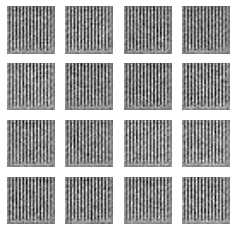

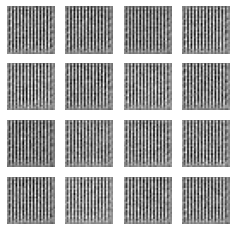

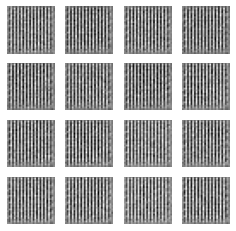

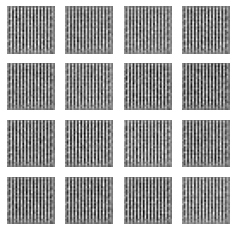

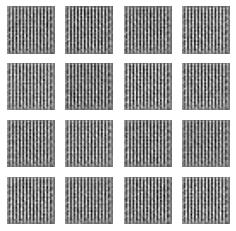

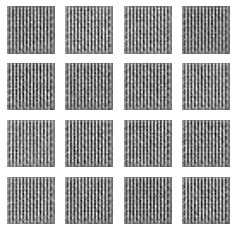

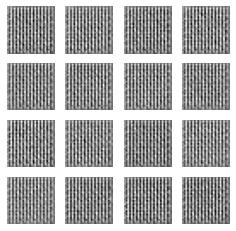

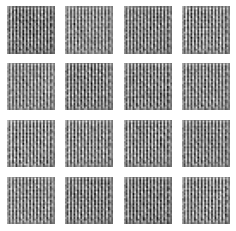

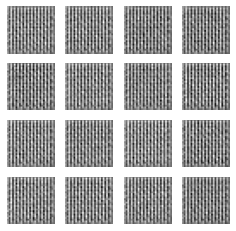

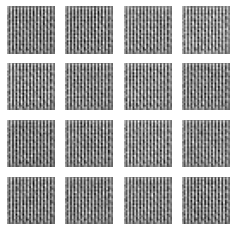

In [112]:
class info:
    
    def __init__(self,losses=[],accuracies=[],iteration_checks=[]):
        
        self.losses = losses
        self.accuracies = accuracies
        self.iteration_checks = iteration_checks
        
Xtrain = Input_Data()
data_size = Xtrain.shape[1:]
batch_size = 64
z_dim = 50

model  = GAN()

model.build_Dis(data_size)
# Dis_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2 = 0.999)
Dis_opt = RMSprop(lr=0.00005) 
model.Dis.compile (loss = Wasserstein_loss,
               optimizer = Dis_opt)

model.build_Gen(z_dim)
# model.Gen.compile(loss = 'binary_crossentropy',
#                optimizer = Adam())

# model.Dis.trainable = False
for layer in model.Dis.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False
            
model.build_GAN()
GAN_opt = RMSprop(lr=0.00005)
# GAN_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2 = 0.999)
model.GAN.compile(loss = Wasserstein_loss,
              optimizer = GAN_opt)

    
Info = info([],[])
Train(batch_size, Xtrain, z_dim, Info, Iters = 100, Interval = 10)